# 3. Develop your own GAN to model data generated as the 'S' alphabet

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from s_dataset import s_dataset

from torch import nn, optim
from torchvision import transforms, datasets

In [18]:
%matplotlib inline

## Write a custom dataset class to generate num_sample number of the 'S' data

In [19]:
#%%
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

#%%
class s_dataset(Dataset):
    
    def __init__(self, num_sample = 1000, transform=None):
        
        pi = np.pi
        self.data = torch.zeros([num_sample,2])

        for i in range(num_sample):
            theta = torch.FloatTensor(1).uniform_(0, 2*pi)
            r = torch.randn(1)
            x = (10+r) * torch.cos(theta)
            

            if 0.5*pi <= theta and theta <= 1.5*pi:
                y = ((10+r) * torch.sin(theta)) + 10
            else:
                y = ((10+r) * torch.sin(theta)) - 10

            self.data[i,0] = x
            self.data[i,1] = y
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data = self.data[index]
        return data

### Get the dataset and plot

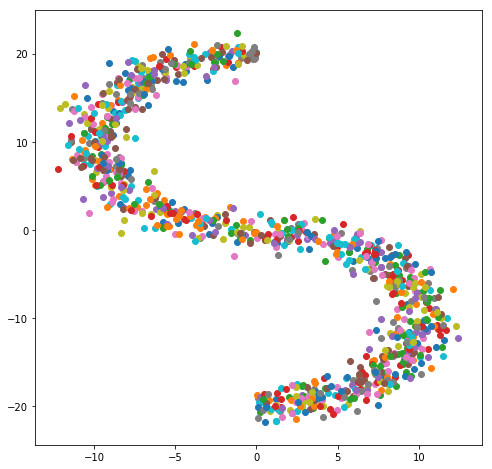

In [20]:
train_dataset = s_dataset(num_sample = 100000, transform=None)

plt.figure(figsize=(8,8))
for i in range(1000):
    data = train_dataset.__getitem__(i)
    plt.scatter(data[0], data[1])
plt.show()

### Load the data into dataloader then plot some examples

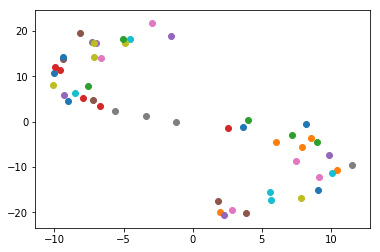

In [21]:
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

for i, data in enumerate(data_loader):
    plt.scatter(data[i,0], data[i,1])
    if i == 50:
        break
plt.figure(figsize=(8,8))
plt.show()

### Set up GAN

In [5]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [6]:
num_batches = len(data_loader)

In [7]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 2
        n_out = 2
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2)
        )

        self.out = nn.Sequential(
            nn.Linear(256, n_out)
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)

        x = self.out(x)
        return x

# Function to create noise samples for the generator's input

# generate size vectors with 100 features
def noise(size):
    n = torch.randn(size, 2) # mean = 0, std = 1
    return n.to(device)

def plt_output(fake_data):
    plt.figure(figsize=(8,8))
    plt.xlim(-20,20)
    plt.ylim(-20,20)
    plt.scatter(fake_data[:,0], fake_data[:,1])
    plt.show()

In [8]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 2
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x

In [9]:
from get_free_gpu import get_free_gpu

device = get_free_gpu()

discriminator = DiscriminatorNet()
generator = GeneratorNet()


discriminator.to(device)
generator.to(device)

GeneratorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [10]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function

loss = nn.BCELoss()

# How many epochs to train for

num_epochs = 50

# Number of steps to apply to the discriminator for each step of the generator (1 in Goodfellow et al.)

d_steps = 1

In [11]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
#     if torch.cuda.is_available(): return data.cuda()
    return data.to(device)

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
#     if torch.cuda.is_available(): return data.cuda()
    return data.to(device)

In [12]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [13]:
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

In [14]:
num_test_samples = 100
test_noise = noise(num_test_samples)

## TRAIN

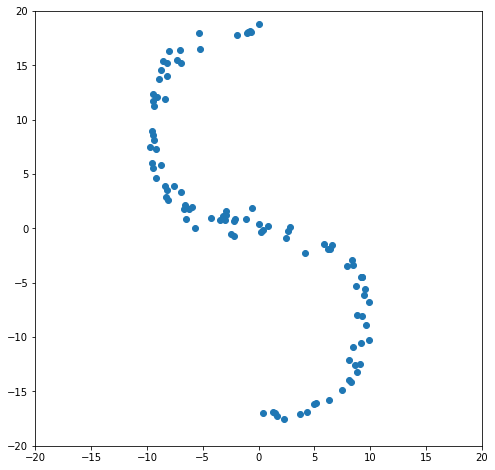

Epoch: [9/50], Batch Num: [900/1000]
Discriminator Loss: 1.3863, Generator Loss: 0.6819
D(x): 0.5052, D(G(z)): 0.5051


In [16]:
logger = Logger(model_name='SnakeGAN', data_name='S')

for epoch in range(10):
    for n_batch, (real_batch) in enumerate(data_loader):

        # Train discriminator on a real batch and a fake batch
        
        real_data = real_batch
#         if torch.cuda.is_available(): real_data = real_data.cuda()
        real_data = real_data.to(device)
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        
        # Train generator

        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log errors and display progress

        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Plotting the generated outputs
            test_plot = plt_output(generator(test_noise).cpu().detach().numpy())
#             logger.log_images(test_plot, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            
        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)

## RESULTS
After training for 50 + 10 = 60 EPOCHS, we got the following data generated form the test_noise.

The distribution of the generated data looks very similar to the real data distribution that we created.

The predicted value from the Discriminator are

        D(x): 0.5052, D(G(z)): 0.5051
        
for the real data and the fake data. They are both 0.50 which means that our GANs can generate the data from the same distribution as the real data perfectly such that the discriminator cannot distinguish between the real and fake data.

Here are the training losses of D and G. If we look at the scale of the y axis we can see that both the G_loss and D_loss has already converged!

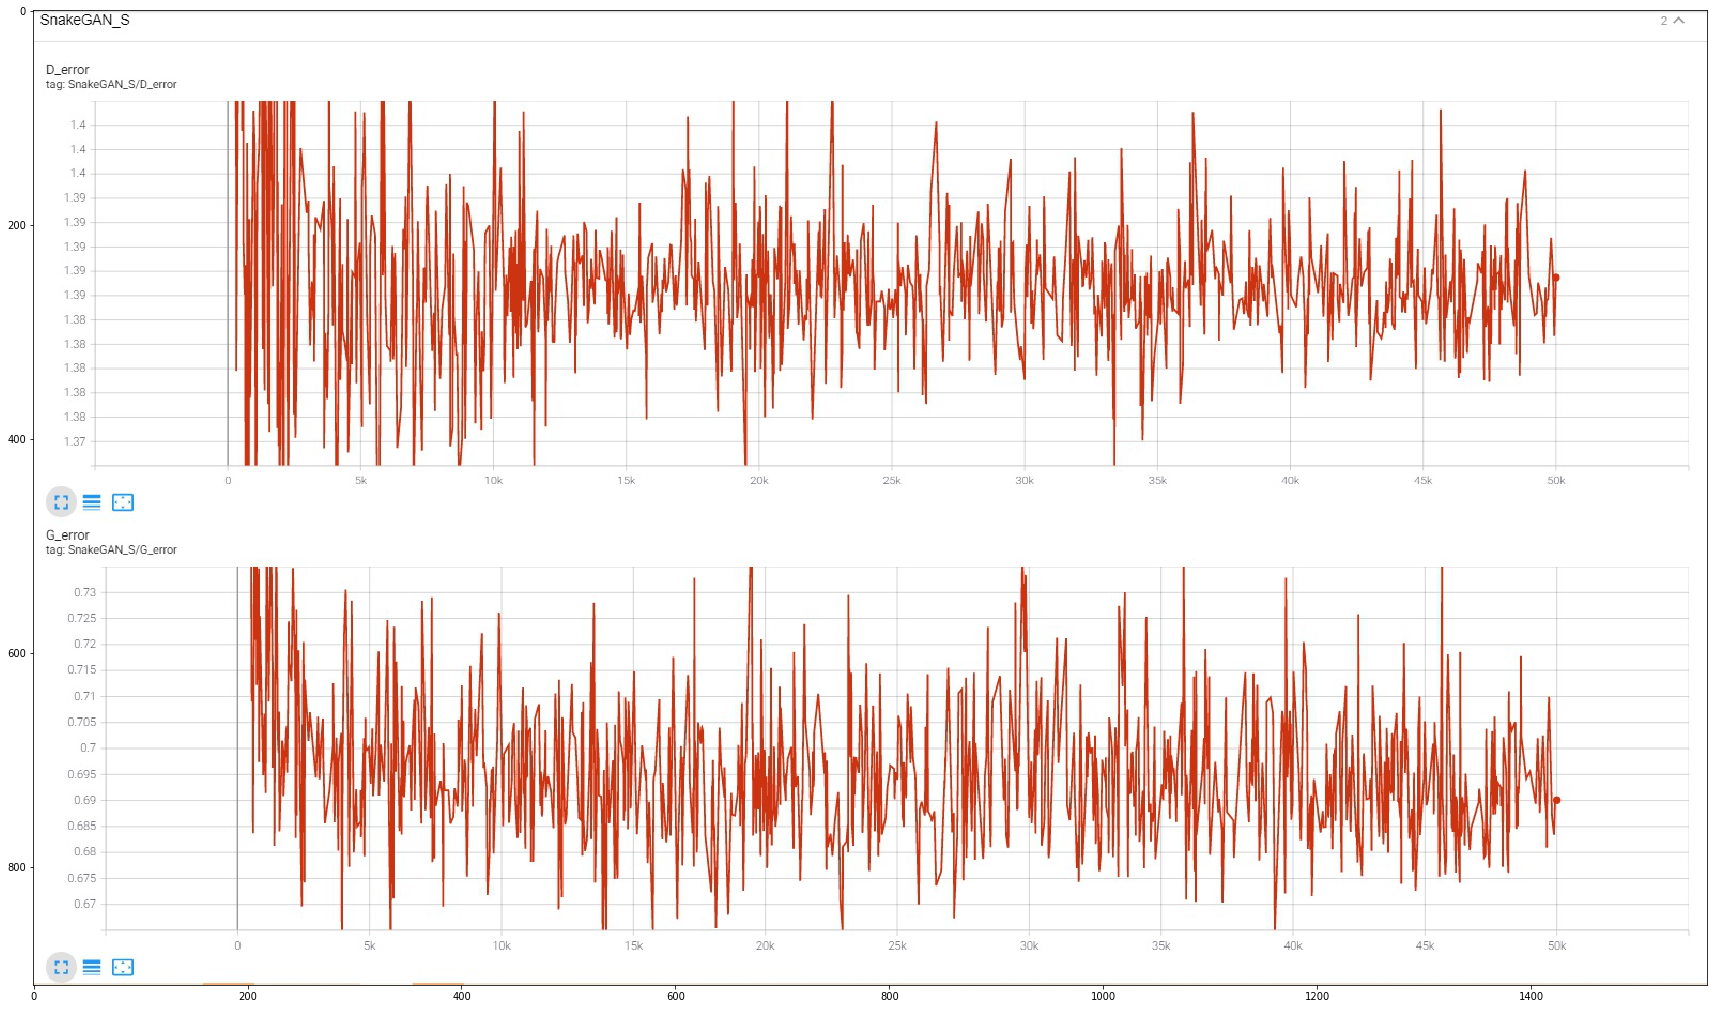

In [22]:
%matplotlib inline 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30)) 
plt.imshow(mpimg.imread('snakeganloss.jpg'))